# Multi-state variational SurvNODE implementation optimizing the ELBO

In this notebook we show examples of the analyses done in the paper using the variational SurvNODE implementation optimizing the ELBO. Pretrained models are available for random_seed=137

In [1]:
import torch
import torch.nn as nn
from torchdiffeq import odeint
# from torchdiffeq import odeint_adjoint as odeint
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from pycox.evaluation import EvalSurv

In [2]:
random_seed = 137
torch.manual_seed(random_seed)
np.random.seed(random_seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print(device)

cuda:0


In [3]:
# Early stopping class from https://github.com/Bjarten/early-stopping-pytorch
from SurvNODE.EarlyStopping import EarlyStopping
from SurvNODE.SurvNODE_variational import *

In [4]:
# Wrapper around pycox EvalSurv to calculate time dependent concordance, integrated Brier score and integrated binomial log likelihood

def measures(odesurv,initial,loader,points=500, inner_samples=1, outer_samples=10, multiplier=1.):
    time_grid = np.linspace(0, multiplier, points)
    with torch.no_grad():
        pvec_vec = []
        Tvec = []
        statusvec = []
        for ds in loader:
            x = ds[1]
            T = ds[3]
            status = ds[7]            
            xrep = x.repeat((inner_samples,1))
            pmean_vec = []
            for i in range(outer_samples):
                surv_ode = odesurv.predict(xrep,torch.from_numpy(np.linspace(0,multiplier,points)).float().to(x.device))
                pvec = torch.einsum("ilkj,k->ilj",(surv_ode[:,:,:,:],initial))[:,:,0].cpu()
                pvec = np.array(pvec.cpu().detach())
                pmean_vec.append(pvec)
            pmean_vec = np.concatenate(pmean_vec,axis=1)
            pvec_mean = pmean_vec.transpose().reshape((int(xrep.shape[0]/x.shape[0]*outer_samples),x.shape[0],points)).mean(axis=0)
            pvec_vec.append(pvec_mean)
            Tvec.append(T.cpu().numpy())
            statusvec.append(status.cpu().numpy())
        pvec_vec = np.concatenate(pvec_vec)
        Tvec = np.concatenate(Tvec)
        statusvec = np.concatenate(statusvec)
        surv_ode_df = pd.DataFrame(pvec_vec.transpose())
        surv_ode_df.loc[:,"time"] = np.linspace(0,multiplier,points)
        surv_ode_df = surv_ode_df.set_index(["time"])
        ev_ode = EvalSurv(surv_ode_df, Tvec, statusvec, censor_surv='km')
        conc = ev_ode.concordance_td('antolini')
        ibs = ev_ode.integrated_brier_score(time_grid)
        inbll = ev_ode.integrated_nbll(time_grid)
    return conc,ibs,inbll

# Application in the survival case

create a binary covariate for the Kaplan-Meier estimates by splitting e.g. $X_3$ into 0/1

In [5]:
survdata = pd.read_csv("Data/survival_sim_km.csv").drop(columns="Unnamed: 0")

In [ ]:
survdata["covar"] = (survdata.X3>0).astype("int")

survdata_train = survdata.sample(n=2048)
survdata_val = survdata[~survdata.index.isin(survdata_train.index)].sample(n=1024)
survdata_test = survdata[~np.logical_or(survdata.index.isin(survdata_train.index),survdata.index.isin(survdata_val.index))].sample(n=1024)

Using the lifelines package, we obtain the non-parametric Kaplan-Meier estimate of the test data. We furthermore train the Cox proportional hazards model on the union of train- and validation data.

In [ ]:
ix = (np.array(survdata_test[["covar"]])==1).flatten()

kmf_exp = KaplanMeierFitter().fit(survdata_test.Tstop[ix], survdata_test.status[ix], label='exp KM')
kmf_con = KaplanMeierFitter().fit(survdata_test.Tstop[~ix], survdata_test.status[~ix], label='con KM')

ix = (np.concatenate((survdata_train.covar,survdata_val.covar))==1).flatten()

cox_df = pd.DataFrame({"T":np.concatenate((survdata_train.Tstop,survdata_val.Tstop)),"E": np.concatenate((survdata_train.status,survdata_val.status)),"group":ix})
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='T', event_col='E')
cph_pred = cph.predict_survival_function(pd.DataFrame({"group":[0,1]}))

Prepare the data loader

In [8]:
def get_dataset(df):
    x = torch.from_numpy(np.array(df[["covar"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tmax = max(Tstop)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["From"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["To"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)
    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(survdata[["Tstop"]])).flatten().float().to(device))

train_loader = DataLoader(get_dataset(survdata_train), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(survdata_val), batch_size=512, shuffle=True)

Initialize the model with the wanted hyperparameters

In [9]:
num_in = 1
num_latent = 70
layers_prior = [400]*2
dropout_prior = [0.]*2
layers_post = [1000]*2
dropout_post = [0.]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

prior_mean = Prior(num_in,num_latent,layers_prior, dropout_prior).to(device)
prior_var = Prior(num_in,num_latent,layers_prior, dropout_prior).to(device)
post_mean = Post(num_in,num_latent,layers_post, dropout_post).to(device)
post_var = Post(num_in,num_latent,layers_post, dropout_post).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc,dropout_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = VarSurvNODE(block,prior_mean,prior_var,post_mean,post_var).to(device)

optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-5, lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

We train the model first with weight decay $10^{-5}$ and a learning rate of $10^{-3}$ and then with a weight decay of $10^{-7}$ and learning rate $10^{-4}$ to refine the solution with early stopping on the validation set

In [10]:
# early_stopping = EarlyStopping("Checkpoints/bayes_survival",patience=20, verbose=True)
# for i in tqdm(range(1000)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/bayes_survival_checkpoint.pt'))

# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-7, lr=1e-4)
# early_stopping = EarlyStopping("Checkpoints/bayes_survival",patience=20, verbose=True)
# for i in tqdm(range(1000)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/bayes_survival_checkpoint.pt'))

Pre-trained model

In [11]:
odesurv.load_state_dict(torch.load('Checkpoints/bayes_survival_checkpoint.pt'))

<All keys matched successfully>

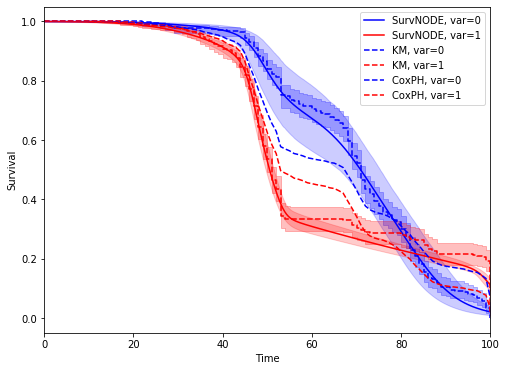

In [12]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8,6))
initial = torch.tensor([1.,0.],device=device)
curve_mean, curve_lower, curve_upper = sample_probs(odesurv,torch.tensor([[0.],[1.]],device=device),initial,inner_samples=200,outer_samples=10)
col_vec = ["blue","red"]
label_vec = ["SurvNODE, var=0","SurvNODE, var=1"]
for s in range(curve_mean.shape[0]):
    ax1.fill_between(np.linspace(0,1,curve_mean.shape[1])*Tmax.cpu().max().numpy(), curve_lower[s,:], curve_upper[s,:],alpha=0.2,color=col_vec[s])
    ax1.plot(np.linspace(0,1,curve_mean.shape[1])*Tmax.cpu().max().numpy(),curve_mean[s,:],color=col_vec[s],label=label_vec[s])
kmf_con.plot(ax=ax1,color="blue",label="KM, var=0",ls="--")
kmf_exp.plot(ax=ax1,color="red",label="KM, var=1",ls="--")
ax1.plot(cph_pred.index,cph_pred[0], label="CoxPH, var=0",color="blue",ls="--")
ax1.plot(cph_pred.index,cph_pred[1], label="CoxPH, var=1",color="red",ls="--")
ax1.legend()
plt.xlabel("Time")
plt.ylabel("Survival")
plt.show()

# Multi-state model

Data generated with "coxed" R package (see supplement), Aalen-Johansen estimator and Markov Cox proportional hazards model generated with "mstate" R package.

In [13]:
prob_hr_train = pd.read_csv("Data/multistate_aj_1_train.csv")
prob_lr_train = pd.read_csv("Data/multistate_aj_0_train.csv")
prob_hr_test = pd.read_csv("Data/multistate_aj_1_train.csv")
prob_lr_test = pd.read_csv("Data/multistate_aj_0_train.csv")
prob_cox_hr = pd.read_csv("Data/multistate_cox_1_train.csv")
prob_cox_lr = pd.read_csv("Data/multistate_cox_0_train.csv")
df_trainval = pd.read_csv("Data/multistate_trainval.csv")
df_test = pd.read_csv("Data/multistate_trainval.csv")

df_train = df_trainval.sample(n=2048)
df_val = df_trainval[~df_trainval.index.isin(df_train.index)].sample(n=1024)

We can again do a visual comparison of the non-parametric Aalen Johansen estimator with the two prediction models: A markovian multistate Cox model and the variational SurvNODE model.

In [14]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[["covariate"]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["from"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["to"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset


multiplier = 1.
Tmax = max(torch.from_numpy(np.array(df_train[["Tstop"]])).flatten().float().to(device))

train_loader = DataLoader(get_dataset(df_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_val,Tmax), batch_size=512, shuffle=True)
val_test = DataLoader(get_dataset(df_test,Tmax), batch_size=512, shuffle=True)

In [15]:
num_in = 1
num_latent = 70
layers_prior = [400]*2
dropout_prior = [0.]*2
layers_post = [1000]*2
dropout_post = [0.]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1,1],[np.nan,np.nan,1],[np.nan,np.nan,np.nan]]).to(device)

prior_mean = Prior(num_in,num_latent,layers_prior, dropout_prior).to(device)
prior_var = Prior(num_in,num_latent,layers_prior, dropout_prior).to(device)
post_mean = Post(num_in,num_latent,layers_post, dropout_post).to(device)
post_var = Post(num_in,num_latent,layers_post, dropout_post).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc,dropout_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = VarSurvNODE(block,prior_mean,prior_var,post_mean,post_var).to(device)


# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

In [16]:
# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-6, lr=5e-4)
# early_stopping = EarlyStopping("Checkpoints/multistate_bayes",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/multistate_bayes_checkpoint.pt'))

# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-7, lr=1e-4)
# early_stopping = EarlyStopping("Checkpoints/multistate_bayes",patience=20, verbose=True)
# for i in tqdm(range(500)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/multistate_bayes_checkpoint.pt'))

Pre-trained model

In [17]:
odesurv.load_state_dict(torch.load('Checkpoints/multistate_bayes_checkpoint.pt'))

<All keys matched successfully>

In [18]:
def sample_probs(odesurv,x,initial, points=500, inner_samples=1, outer_samples=1, multiplier=1.):
    """
        sample probabilites from 0 to multiplier at "points" number of points from initial state "initial" (e.g. [1,0,0] in the illness-death case starting out at Health)
    """    
    xrep = x.repeat(inner_samples,1)
    curve_vec = []
    for _ in range(outer_samples):
        surv_ode = odesurv.predict(xrep,torch.from_numpy(np.linspace(0,multiplier,points)).float().to(x.device))
        pvec = torch.einsum("ilkj,k->ilj",(surv_ode[:,:,:,:],initial))
        samp_curves = pvec.cpu().numpy()
        samp_curves = samp_curves.transpose().reshape((initial.shape[0],int(xrep.shape[0]/x.shape[0]),x.shape[0],points))
        curve_vec.append(samp_curves)
    curve_vec = np.concatenate(curve_vec, axis=1)
    curve_mean = np.mean(curve_vec,axis=1)
    curve_upper = np.percentile(curve_vec,95,axis=1)
    curve_lower = np.percentile(curve_vec,5,axis=1)
    return curve_mean, curve_lower ,curve_upper

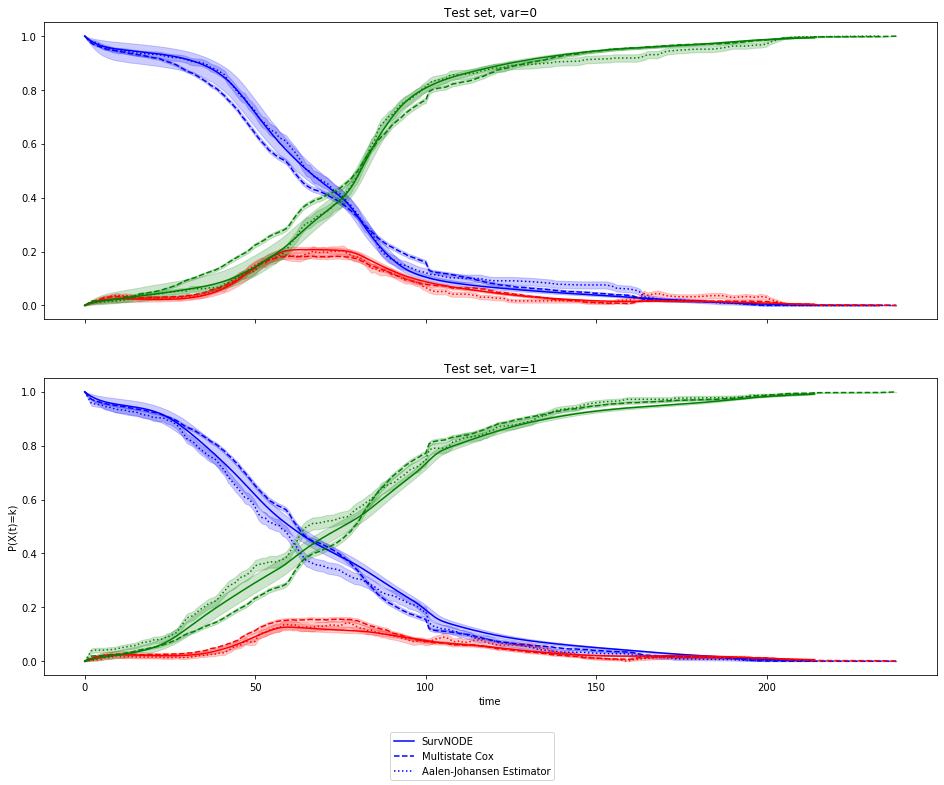

In [19]:
curve_mean, curve_lower, curve_upper = sample_probs(odesurv,torch.tensor([[0.],[1.]],device=device),torch.tensor([1.,0.,0.],device=device),inner_samples=200,outer_samples=10)

fig,((ax1,ax2)) = plt.subplots(2,1,figsize=(16,12),sharex=True,sharey=True)
col_vec = ["blue","red","green"]
for j in range(curve_mean.shape[0]):
    ax1.fill_between(np.linspace(0,1,curve_mean.shape[-1])*Tmax.cpu().max().numpy(), curve_lower[j,0,:], curve_upper[j,0,:],alpha=0.2,color=col_vec[j])
    ax1.plot(np.linspace(0,1,curve_mean.shape[-1])*Tmax.cpu().max().numpy(),curve_mean[j,0,:],color=col_vec[j])
    ax1.plot(prob_cox_lr[["time"]],prob_cox_lr[["pstate"+str(j+1)]],color=col_vec[j], ls="--")
    ax1.fill_between(np.array(prob_cox_lr[["time"]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_lr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_lr[["se"+str(j+1)]]).flatten(),color=col_vec[j],alpha=0.2)
    ax1.plot(prob_lr_test[["time"]],prob_lr_test[["pstate"+str(j+1)]],color=col_vec[j],ls=":")
    ax1.fill_between(np.array(prob_lr_test[["time"]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),np.array(prob_lr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_lr_test[["se"+str(j+1)]]).flatten(),color=col_vec[j],alpha=0.2)
ax1.set_title("Test set, var=0")
for j in range(curve_mean.shape[0]):
    ax2.fill_between(np.linspace(0,1,curve_mean.shape[-1])*Tmax.cpu().max().numpy(), curve_lower[j,1,:], curve_upper[j,1,:],alpha=0.2,color=col_vec[j])
    ax2.plot(np.linspace(0,1,curve_mean.shape[-1])*Tmax.cpu().max().numpy(),curve_mean[j,1,:],color=col_vec[j], label="SurvNODE")
    ax2.plot(prob_cox_hr[["time"]],prob_cox_hr[["pstate"+str(j+1)]],color=col_vec[j], ls="--",label="Multistate Cox")
    ax2.fill_between(np.array(prob_cox_hr[["time"]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()-np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),np.array(prob_cox_hr[["pstate"+str(j+1)]]).flatten()+np.array(prob_cox_hr[["se"+str(j+1)]]).flatten(),color=col_vec[j],alpha=0.2)
    ax2.plot(prob_hr_test[["time"]],prob_hr_test[["pstate"+str(j+1)]],color=col_vec[j],ls=":",label="Aalen-Johansen Estimator")
    ax2.fill_between(np.array(prob_hr_test[["time"]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()-np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),np.array(prob_hr_test[["pstate"+str(j+1)]]).flatten()+np.array(prob_hr_test[["se"+str(j+1)]]).flatten(),color=col_vec[j],alpha=0.2)
ax2.set_title("Test set, var=1")
plt.xlabel("time")
plt.ylabel("P(X(t)=k)")
handles, labels = ax2.get_legend_handles_labels()
fig.legend([handles[0],handles[1],handles[2]],[labels[0],labels[1],labels[2]], loc='lower center')
plt.show()

# Survival Clustering

For the clustering we split the three covariates into three bins each, to be able to interpret the clusters

In [20]:
survdata = pd.read_csv("Data/survival_sim_km.csv").drop(columns="Unnamed: 0")

survdata['X1'] = pd.qcut(survdata['X1'].values, 3).codes + 1
survdata['X2'] = pd.qcut(survdata['X2'].values, 3).codes + 1
survdata['X3'] = pd.qcut(survdata['X3'].values, 3).codes + 1
survdata = pd.get_dummies(survdata, columns=["X1","X2","X3"])

In [21]:
survdata_train = survdata.sample(n=2048)
survdata_test = survdata[~survdata.index.isin(survdata_train.index)].sample(n=2048)

In [22]:
def get_dataset(df,Tmax):
    x = torch.from_numpy(np.array(df[np.array(survdata.columns)[["X" in i for i in np.array(survdata.columns)]]])).float().to(device)
    Tstart = torch.from_numpy(np.array(df[["Tstart"]])).flatten().float().to(device)
    Tstop = torch.from_numpy(np.array(df[["Tstop"]])).flatten().float().to(device)
    Tstart = Tstart/Tmax*multiplier
    Tstop = Tstop/Tmax*multiplier
    From = torch.from_numpy(np.array(df[["From"]])).flatten().int().to(device)
    To = torch.from_numpy(np.array(df[["To"]])).flatten().int().to(device)
    trans = torch.from_numpy(np.array(df[["trans"]])).flatten().int().to(device)
    status = torch.from_numpy(np.array(df[["status"]])).flatten().float().to(device)

    dataset = TensorDataset(x,Tstart,Tstop,From,To,trans,status)
    return dataset

multiplier = 1.
Tmax = max(torch.from_numpy(np.array(survdata[["Tstop"]])).flatten().float().to(device))

df_train = survdata_train
df_test = survdata_test

train_loader = DataLoader(get_dataset(df_train,Tmax), batch_size=512, shuffle=True)
val_loader = DataLoader(get_dataset(df_test,Tmax), batch_size=512, shuffle=True)

In [23]:
num_in = 9
num_latent = 70
layers_prior = [400]*2
dropout_prior = [0.]*2
layers_post = [1000]*2
dropout_post = [0.]*2
layers_odefunc = [1000]*3
dropout_odefunc = []

trans_matrix = torch.tensor([[np.nan,1],[np.nan,np.nan]]).to(device)

prior_mean = Prior(num_in,num_latent,layers_prior, dropout_prior).to(device)
prior_var = Prior(num_in,num_latent,layers_prior, dropout_prior).to(device)
post_mean = Post(num_in,num_latent,layers_post, dropout_post).to(device)
post_var = Post(num_in,num_latent,layers_post, dropout_post).to(device)
odefunc = ODEFunc(trans_matrix,num_in,num_latent,layers_odefunc,dropout_odefunc).to(device)
block = ODEBlock(odefunc).to(device)
odesurv = VarSurvNODE(block,prior_mean,prior_var,post_mean,post_var).to(device)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.1)

In [24]:
# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-5, lr=1e-4)
# early_stopping = EarlyStopping("Checkpoints/bayes_survival_cluster",patience=20, verbose=True)
# for i in tqdm(range(1000)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/bayes_survival_cluster.pt'))

# optimizer = torch.optim.Adam(odesurv.parameters(), weight_decay = 1e-7, lr=1e-4)
# early_stopping = EarlyStopping("Checkpoints/bayes_survival_cluster",patience=20, verbose=True)
# for i in tqdm(range(1000)):
#     odesurv.train()
#     for mini,ds in enumerate(train_loader):
#         myloss,t2,_,_ = loss(odesurv,*ds)
#         optimizer.zero_grad()
#         myloss.backward()    
#         optimizer.step()
        
#     odesurv.eval()
#     with torch.no_grad():
#         lossval = 0
#         for _,ds in enumerate(val_loader):
#             t1,t2,_,_ = loss(odesurv,*ds)
#             lossval += t1.item()
    
# #     scheduler.step()
#     early_stopping(lossval/len(val_loader), odesurv)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break
        
# odesurv.load_state_dict(torch.load('Checkpoints/bayes_survival_cluster_checkpoint.pt'))

Pre-trained model

In [25]:
odesurv.load_state_dict(torch.load('Checkpoints/bayes_survival_cluster_checkpoint.pt'))

<All keys matched successfully>

We do a UMAP projection of the resulting survival clusters and use KMeans to identify those clusters. We produce a Kaplan-Meier estimate for each cluster and plot the resulting curves

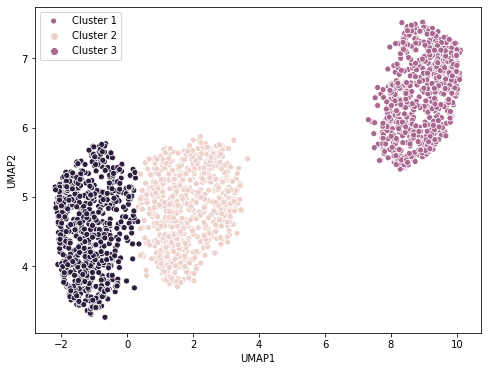

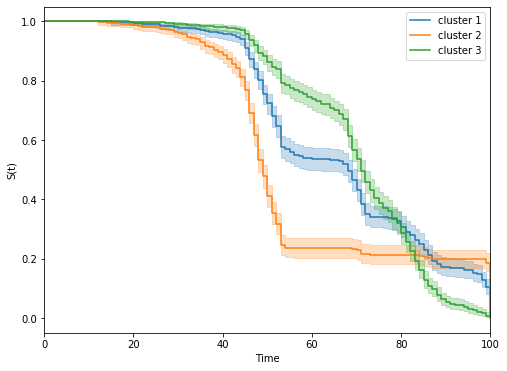

In [26]:
from sklearn.cluster import KMeans
import umap
import seaborn as sns

x_vec = []
z0_vec = []
T_vec = []
event_vec = []
for _,ds in enumerate(val_loader):
    x,z0 = odesurv.sample_latent(ds[0])
    x_vec.append(x.cpu().numpy())
    z0_vec.append(z0.cpu().numpy())
    T_vec.append(ds[2].cpu().numpy())
    event_vec.append(ds[6].cpu().numpy())
    
x_vec = np.concatenate(x_vec)
z0_vec = np.concatenate(z0_vec)
T_vec = np.concatenate(T_vec)
event_vec = np.concatenate(event_vec)
umap_vec = umap.UMAP(min_dist=0,n_neighbors=15).fit_transform(pd.DataFrame(z0_vec))

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters).fit(umap_vec)
kmeans_labels = kmeans.labels_

plt.figure(figsize=(8,6))
sns.scatterplot(umap_vec[:,0],umap_vec[:,1],kmeans_labels)
plt.legend(["Cluster "+str(i+1) for i in list(np.unique(kmeans_labels))])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

kmf_fits = []
for i in range(num_clusters):
    kmf = KaplanMeierFitter().fit(T_vec[kmeans_labels==i]*100, event_vec[kmeans_labels==i], label='cluster '+str(i+1))
    kmf_fits.append(kmf)
    
plt.figure(figsize=(8,6))
ax = kmf_fits[0].plot()
for i in range(1,num_clusters):
    kmf_fits[i].plot(ax=ax)
plt.legend()
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.show()